# Project Title
### Data Engineering Capstone Project

#### Project Summary
--describe your project at a high level--

The project follows the follow steps:
* Step 1: Scope the Project and Gather Data
* Step 2: Explore and Assess the Data
* Step 3: Define the Data Model
* Step 4: Run ETL to Model the Data
* Step 5: Complete Project Write Up

In [1]:
# Do all imports and installs here
import logging
import numpy as np
import pandas as pd
import psycopg2
from pprint import pprint
import configparser
import psycopg2
import pandas as pd
pd.set_option('display.max_columns', None)
import os
from pyspark.sql import SparkSession, DataFrame
from pyspark.sql.types import StructType as R, StructField as Fld, DoubleType as Dbl, StringType as Str, IntegerType as Int, DateType as Date
from collections import OrderedDict 
from datetime import datetime, timedelta

logging.basicConfig(level=logging.INFO, format='%(asctime)s %(levelname)s  [%(name)s] %(message)s')
LOG = logging.getLogger('etl')

### Step 1: Scope the Project and Gather Data

#### Scope 
Explain what you plan to do in the project in more detail. What data do you use? What is your end solution look like? What tools did you use? etc>

#### Describe and Gather Data 
Describe the data sets you're using. Where did it come from? What type of information is included? 

In [2]:
# Read in the data here
imm_sample = pd.read_csv('./immigration_data_sample.csv')
imm_sample.head()
imm_header = list(imm_sample.head(0))
imm_header = imm_header[1:]
pprint(imm_header)

['cicid',
 'i94yr',
 'i94mon',
 'i94cit',
 'i94res',
 'i94port',
 'arrdate',
 'i94mode',
 'i94addr',
 'depdate',
 'i94bir',
 'i94visa',
 'count',
 'dtadfile',
 'visapost',
 'occup',
 'entdepa',
 'entdepd',
 'entdepu',
 'matflag',
 'biryear',
 'dtaddto',
 'gender',
 'insnum',
 'airline',
 'admnum',
 'fltno',
 'visatype']


In [114]:
# .config("spark.jars.packages","org.apache.hadoop:hadoop-aws:2.7.0") \
# .config("spark.jars.packages", "saurfang:spark-sas7bdat:3.0.0-s_2.12") \
from pyspark.sql import SparkSession
spark = SparkSession.builder \
                     .config("spark.jars.packages","org.apache.hadoop:hadoop-aws:2.7.0") \
                    .enableHiveSupport() \
                    .getOrCreate()
# df_spark =spark.read.format('com.github.saurfang.sas.spark').load('../../data/18-83510-I94-Data-2016/i94_apr16_sub.sas7bdat')

In [4]:
#write to parquet
# df_spark.write.parquet("sas_data")
# df_spark=spark.read.parquet("sas_data")

### Step 2: Explore and Assess the Data
#### Explore the Data 
Identify data quality issues, like missing values, duplicate data, etc.

#### Cleaning Steps
Document steps necessary to clean the data

# Performing cleaning tasks here
* Checkout i94 2016 data
* Checkout demographics data
* Checkout airport data
* Checkout temperature data

# get valid values of I94 fields

In [157]:
# try configparsing
config = configparser.ConfigParser()
config.read_file(open('meta_i94.cfg'))

pprint(config['I94MODE'])

<Section: I94MODE>


In [158]:
sections_dict = {}
# get sections and iterate over each
sections = config.sections()

for section in sections:
    options = config.options(section)
    temp_dict = {}
    for option in options:
        k = option.strip('\'').strip().upper()
        v = config.get(section,option).strip('\'').strip().upper()
        temp_dict[k] = v

    sections_dict[section] = temp_dict

In [159]:
# cast meta key into it's original type
meta_i94 = {}
for k, v in sections_dict.items():
    print(k)
    if k == 'I94CIT' or k == 'I94MODE':
        meta_i94[k] = {int(vk):vv for vk,vv in v.items()}
    else:
        meta_i94[k] = v

I94CIT
I94PORT
I94MODE
I94ADDR


## i94 data

In [168]:
i94_fnames=['./data/18-83510-I94-Data-2016/i94_jan16_sub.sas7bdat',
            './data/18-83510-I94-Data-2016/i94_feb16_sub.sas7bdat',
            './data/18-83510-I94-Data-2016/i94_mar16_sub.sas7bdat',
            './data/18-83510-I94-Data-2016/i94_apr16_sub.sas7bdat',
            './data/18-83510-I94-Data-2016/i94_may16_sub.sas7bdat',
            './data/18-83510-I94-Data-2016/i94_jun16_sub.sas7bdat',
            './data/18-83510-I94-Data-2016/i94_jul16_sub.sas7bdat',
            './data/18-83510-I94-Data-2016/i94_aug16_sub.sas7bdat',
            './data/18-83510-I94-Data-2016/i94_sep16_sub.sas7bdat',
            './data/18-83510-I94-Data-2016/i94_oct16_sub.sas7bdat',
            './data/18-83510-I94-Data-2016/i94_nov16_sub.sas7bdat',
            './data/18-83510-I94-Data-2016/i94_dec16_sub.sas7bdat']

In [216]:
CustomI94Schema = R([
    Fld("cicid", Int()),
    Fld("i94yr", Int()),
    Fld("i94mon", Int()),  
    Fld("i94cit", Int()),  
    Fld("i94res", Int()),  
    Fld("i94port", Str()), 
    Fld("arrdate", Int()), 
    Fld("i94mode", Int()), 
    Fld("i94addr", Str()), 
    Fld("depdate", Int()), 
    Fld("i94bir", Int()),  
    Fld("i94visa", Int()), 
    Fld("count", Int()),
    Fld("dtadfile", Str()),
    Fld("visapost", Str()),
    Fld("occup", Str()),
    Fld("entdepa", Str()), 
    Fld("entdepd", Str()), 
    Fld("entdepu", Str()),
    Fld("matflag", Str()),  
    Fld("biryear", Int()), 
    Fld("dtaddto", Str()),
    Fld("gender", Str()),  
    Fld("insnum", Str()),  
    Fld("airline", Str()), 
    Fld("admnum", Dbl()),  
    Fld("fltno", Str()),
    Fld("visatype", Str())
])

CustomI94JunSchema = R([
    Fld("cicid", Int()),
    Fld("i94yr", Int()),
    Fld("i94mon", Int()),  
    Fld("i94cit", Int()),  
    Fld("i94res", Int()),  
    Fld("i94port", Str()), 
    Fld("arrdate", Int()), 
    Fld("i94mode", Int()), 
    Fld("i94addr", Str()), 
    Fld("depdate", Int()), 
    Fld("i94bir", Int()),  
    Fld("i94visa", Int()), 
    Fld("count", Int()),
    Fld("validres", Int()),
    Fld("delete_days", Int()),
    Fld("delete_mexl", Int()),
    Fld("delete_dup", Int()),
    Fld("delete_visa", Int()), 
    Fld("delete_recdup", Int()),
    Fld("dtadfile", Str()),
    Fld("visapost", Str()),
    Fld("occup", Str()),
    Fld("entdepa", Str()), 
    Fld("entdepd", Str()), 
    Fld("entdepu", Str()),
    Fld("matflag", Str()),  
    Fld("biryear", Int()), 
    Fld("dtaddto", Str()),
    Fld("gender", Str()),  
    Fld("insnum", Str()),  
    Fld("airline", Str()), 
    Fld("admnum", Dbl()),  
    Fld("fltno", Str()),
    Fld("visatype", Str())
])

In [224]:
# Examine i94 data
columns_to_drop = ['validres', 'delete_days', 'delete_mexl', 'delete_dup', 'delete_visa', 'delete_recdup']
df_i94s = OrderedDict() 
for f in i94_fnames:
    fname = os.path.basename(f)
    print(fname)
    if "jun" in fname: 
        d = spark.read.schema(CustomI94JunSchema).format('com.github.saurfang.sas.spark').load(f)
        d = d.drop(*columns_to_drop)
    else:
        d = spark.read.schema(CustomI94Schema).format('com.github.saurfang.sas.spark').load(f)
#     d = d.dropna(subset=["cicid", "arrdate", "i94addr"]).dropDuplicates()
    df_i94s[fname] = d
    d.printSchema()
    d.show()

i94_jan16_sub.sas7bdat
root
 |-- cicid: integer (nullable = true)
 |-- i94yr: integer (nullable = true)
 |-- i94mon: integer (nullable = true)
 |-- i94cit: integer (nullable = true)
 |-- i94res: integer (nullable = true)
 |-- i94port: string (nullable = true)
 |-- arrdate: integer (nullable = true)
 |-- i94mode: integer (nullable = true)
 |-- i94addr: string (nullable = true)
 |-- depdate: integer (nullable = true)
 |-- i94bir: integer (nullable = true)
 |-- i94visa: integer (nullable = true)
 |-- count: integer (nullable = true)
 |-- dtadfile: string (nullable = true)
 |-- visapost: string (nullable = true)
 |-- occup: string (nullable = true)
 |-- entdepa: string (nullable = true)
 |-- entdepd: string (nullable = true)
 |-- entdepu: string (nullable = true)
 |-- matflag: string (nullable = true)
 |-- biryear: integer (nullable = true)
 |-- dtaddto: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- insnum: string (nullable = true)
 |-- airline: string (nullable = tru

In [225]:
# define sample rate so that each month got same # of rows in union i94 df.
## get file size of each month i94 by ../../data/18-83510-I94-Data-2016/
# i94_filesizes = [415, 374, 459, 451, 501, 684, 620, 597, 543, 531, 424, 500]
# i94_samplerate = []
# N = 5
# for i in i94_filesizes:
#     i94_samplerate.append(N/i)
# print(i94_samplerate)

# i94_samplerate_dict = {}
# i = 0
# for k in df_i94s.keys():
#     i94_samplerate_dict[k] = i94_samplerate[i]
#     i = i+1
# pprint(i94_samplerate_dict)

In [226]:
# sample 1% of each month of i94, since origin size of sas is around 500MB.
sample_rate = 0.1
df_i94s_sample = {}
for k, v in df_i94s.items():
    df_i94s_sample[k] = v.sample(sample_rate)
    
from functools import reduce
print(len(df_i94s_sample.values()))
df_i94s_sample_unionall = reduce(DataFrame.unionAll, df_i94s_sample.values())

df_i94s_sample_unionall.printSchema()

12
root
 |-- cicid: integer (nullable = true)
 |-- i94yr: integer (nullable = true)
 |-- i94mon: integer (nullable = true)
 |-- i94cit: integer (nullable = true)
 |-- i94res: integer (nullable = true)
 |-- i94port: string (nullable = true)
 |-- arrdate: integer (nullable = true)
 |-- i94mode: integer (nullable = true)
 |-- i94addr: string (nullable = true)
 |-- depdate: integer (nullable = true)
 |-- i94bir: integer (nullable = true)
 |-- i94visa: integer (nullable = true)
 |-- count: integer (nullable = true)
 |-- dtadfile: string (nullable = true)
 |-- visapost: string (nullable = true)
 |-- occup: string (nullable = true)
 |-- entdepa: string (nullable = true)
 |-- entdepd: string (nullable = true)
 |-- entdepu: string (nullable = true)
 |-- matflag: string (nullable = true)
 |-- biryear: integer (nullable = true)
 |-- dtaddto: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- insnum: string (nullable = true)
 |-- airline: string (nullable = true)
 |-- admnum: doub

In [227]:
df_i94s_sample_unionall.write.mode('overwrite').parquet(path='i94_sample.parquet')

In [16]:
# df_i94s_sample_unionall.createOrReplaceTempView("i94")
# play = spark.sql("""
# select distinct cicid,
#                 i94mon,
#                 i94cit,
#                 airline,
#                 visatype
# from i94
# """)
# play.printSchema()
# play.show(5)

In [228]:
%%time
df_sas = spark.read.parquet('sas_data/')
df_sas.count()

CPU times: user 3.53 ms, sys: 99 µs, total: 3.63 ms
Wall time: 281 ms


3096313

In [229]:
%%time
df_imm = spark.read.parquet('i94_sample.parquet/')
df_imm = df_imm.dropna(subset=["cicid", "arrdate", "i94addr"]).dropDuplicates()
LOG.info(df_imm.count())
df_imm.printSchema()
df_imm.show()

2020-09-30 15:34:39,313 INFO  [etl] 3876290


root
 |-- cicid: integer (nullable = true)
 |-- i94yr: integer (nullable = true)
 |-- i94mon: integer (nullable = true)
 |-- i94cit: integer (nullable = true)
 |-- i94res: integer (nullable = true)
 |-- i94port: string (nullable = true)
 |-- arrdate: integer (nullable = true)
 |-- i94mode: integer (nullable = true)
 |-- i94addr: string (nullable = true)
 |-- depdate: integer (nullable = true)
 |-- i94bir: integer (nullable = true)
 |-- i94visa: integer (nullable = true)
 |-- count: integer (nullable = true)
 |-- dtadfile: string (nullable = true)
 |-- visapost: string (nullable = true)
 |-- occup: string (nullable = true)
 |-- entdepa: string (nullable = true)
 |-- entdepd: string (nullable = true)
 |-- entdepu: string (nullable = true)
 |-- matflag: string (nullable = true)
 |-- biryear: integer (nullable = true)
 |-- dtaddto: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- insnum: string (nullable = true)
 |-- airline: string (nullable = true)
 |-- admnum: double 

In [230]:
staging_imm = df_imm.createOrReplaceTempView("imm")

In [231]:
imm_table = spark.sql("""
select distinct i94mon, COUNT(*)
FROM imm
GROUP BY 1
ORDER BY 1 asc
""")
imm_table.printSchema()
imm_table.show()
LOG.info(f"total 1% sample parquet rows: {imm_table.count()}")

root
 |-- i94mon: integer (nullable = true)
 |-- count(1): long (nullable = false)

+------+--------+
|i94mon|count(1)|
+------+--------+
|     1|  266575|
|     2|  242051|
|     3|  298831|
|     4|  295586|
|     5|  326718|
|     6|  338932|
|     7|  406657|
|     8|  392166|
|     9|  357469|
|    10|  349138|
|    11|  275624|
|    12|  326543|
+------+--------+



2020-09-30 15:35:50,119 INFO  [etl] total 1% sample parquet rows: 12


In [103]:
test = spark.sql("""
select cicid, count(*)
from imm
group by 1
having count(cicid) > 1
order by 2
""")
test.printSchema()
test.show()
test.count()

root
 |-- cicid: double (nullable = true)
 |-- count(1): long (nullable = false)

+---------+--------+
|    cicid|count(1)|
+---------+--------+
|5752448.0|       2|
|6028733.0|       2|
|5756431.0|       2|
|6971065.0|       2|
|5779297.0|       2|
|7008067.0|       2|
|5784594.0|       2|
|7056369.0|       2|
|5788402.0|       2|
|7200003.0|       2|
|5793057.0|       2|
|7233934.0|       2|
|5812202.0|       2|
|5695056.0|       2|
|5818647.0|       2|
|5703762.0|       2|
|5932601.0|       2|
|5710029.0|       2|
|5938899.0|       2|
|5722729.0|       2|
+---------+--------+
only showing top 20 rows



786911

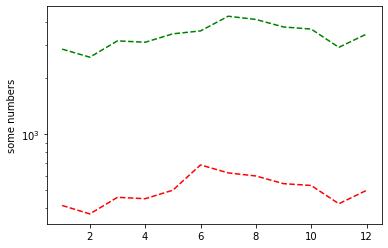

In [43]:
import matplotlib.pyplot as plt
t = [1,2,3,4,5,6,7,8,9,10,11,12]
filesize_in_MB = [415 ,374 ,459 ,451 ,501 ,684 ,620 ,597 ,543 ,531 ,424 ,500]
sample_in_rows = [284968,257999,315522,310147,344054,356638,427332,410803,374449,364811,291295,343157] 
sample_in_rows_lower = [s/100 for s in sample_in_rows ]
plt.plot(t, filesize_in_MB, 'r--', t, sample_in_rows_lower, 'g--' )
plt.ylabel('some numbers')
plt.yscale('log')
plt.show()

## Extract i94 table from dataframe

In [44]:
staging_imm = df_imm.createOrReplaceTempView("imm")

In [212]:
df_imm.createOrReplaceTempView("castExample")
df1 = spark.sql("""
SELECT 
    distinct cicid as cid,
    i94yr,
    i94mon
    i94cit,
    i94res,
    i94port,
    i94addr,
    date_add('1960-01-01',arrdate) as arrdate
FROM castExample
where cicid is not NULL and i94addr is not null
""")
df1.printSchema()
df1.show()

root
 |-- cid: integer (nullable = true)
 |-- i94yr: integer (nullable = true)
 |-- i94cit: integer (nullable = true)
 |-- i94res: integer (nullable = true)
 |-- i94port: string (nullable = true)
 |-- i94addr: string (nullable = true)
 |-- arrdate: date (nullable = true)

+-------+-----+------+------+-------+-------+----------+
|    cid|i94yr|i94cit|i94res|i94port|i94addr|   arrdate|
+-------+-----+------+------+-------+-------+----------+
|6937141| 2016|     7|   245|    SFR|     NV|2016-07-29|
|6937310| 2016|     7|   129|    NYC|     NY|2016-07-29|
|6938444| 2016|     7|   509|    XXX|     GA|2016-07-29|
|6941273| 2016|     7|   135|    WAS|     MD|2016-07-29|
|6941562| 2016|     7|   111|    ATL|     GA|2016-07-29|
|6946552| 2016|     7|   112|    BOS|     MA|2016-07-29|
|6946591| 2016|     7|   263|    HHW|     HI|2016-07-29|
|6946932| 2016|     7|   104|    WAS|     CO|2016-07-29|
|6947336| 2016|     7|   111|    LOS|     CA|2016-07-29|
|6952378| 2016|     7|   209|    HHW|     H

## demographics data

In [31]:
df_degh = spark.read.options(header='True',inferSchema='True',sep=';').csv('./us-cities-demographics.csv')
df_degh.printSchema()
df_degh.show(5)

root
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Median Age: double (nullable = true)
 |-- Male Population: integer (nullable = true)
 |-- Female Population: integer (nullable = true)
 |-- Total Population: integer (nullable = true)
 |-- Number of Veterans: integer (nullable = true)
 |-- Foreign-born: integer (nullable = true)
 |-- Average Household Size: double (nullable = true)
 |-- State Code: string (nullable = true)
 |-- Race: string (nullable = true)
 |-- Count: integer (nullable = true)

+----------------+-------------+----------+---------------+-----------------+----------------+------------------+------------+----------------------+----------+--------------------+-----+
|            City|        State|Median Age|Male Population|Female Population|Total Population|Number of Veterans|Foreign-born|Average Household Size|State Code|                Race|Count|
+----------------+-------------+----------+---------------+-----------------+-------------

## Checkout airport data

In [32]:
df_air = spark.read.options(header='True',inferSchema='True').csv('./airport-codes_csv.csv')
df_air.printSchema()
df_air.show(5)

root
 |-- ident: string (nullable = true)
 |-- type: string (nullable = true)
 |-- name: string (nullable = true)
 |-- elevation_ft: integer (nullable = true)
 |-- continent: string (nullable = true)
 |-- iso_country: string (nullable = true)
 |-- iso_region: string (nullable = true)
 |-- municipality: string (nullable = true)
 |-- gps_code: string (nullable = true)
 |-- iata_code: string (nullable = true)
 |-- local_code: string (nullable = true)
 |-- coordinates: string (nullable = true)

+-----+-------------+--------------------+------------+---------+-----------+----------+------------+--------+---------+----------+--------------------+
|ident|         type|                name|elevation_ft|continent|iso_country|iso_region|municipality|gps_code|iata_code|local_code|         coordinates|
+-----+-------------+--------------------+------------+---------+-----------+----------+------------+--------+---------+----------+--------------------+
|  00A|     heliport|   Total Rf Heliport|   

## Checkout temperature data

In [33]:
df_tmpt = spark.read.options(header='True', inferSchema='True').csv('./GlobalLandTemperaturesByCity.csv')
df_tmpt = df_tmpt.filter(df_tmptt.Country == "United States")
df_tmpt.printSchema()
df_tmpt.show(5)

root
 |-- dt: timestamp (nullable = true)
 |-- AverageTemperature: double (nullable = true)
 |-- AverageTemperatureUncertainty: double (nullable = true)
 |-- City: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Latitude: string (nullable = true)
 |-- Longitude: string (nullable = true)

+-------------------+------------------+-----------------------------+-----+-------+--------+---------+
|                 dt|AverageTemperature|AverageTemperatureUncertainty| City|Country|Latitude|Longitude|
+-------------------+------------------+-----------------------------+-----+-------+--------+---------+
|1743-11-01 00:00:00|             6.068|           1.7369999999999999|Århus|Denmark|  57.05N|   10.33E|
|1743-12-01 00:00:00|              null|                         null|Århus|Denmark|  57.05N|   10.33E|
|1744-01-01 00:00:00|              null|                         null|Århus|Denmark|  57.05N|   10.33E|
|1744-02-01 00:00:00|              null|                         n

In [ ]:
df_tmpt.write.mode('overwrite').parquet(path='temperature_us.parquet')

### Step 3: Define the Data Model
#### 3.1 Conceptual Data Model
Map out the conceptual data model and explain why you chose that model

#### 3.2 Mapping Out Data Pipelines
List the steps necessary to pipeline the data into the chosen data model

### Step 4: Run Pipelines to Model the Data 
#### 4.1 Create the data model
Build the data pipelines to create the data model.

In [ ]:
# Write code here

#### 4.2 Data Quality Checks
Explain the data quality checks you'll perform to ensure the pipeline ran as expected. These could include:
 * Integrity constraints on the relational database (e.g., unique key, data type, etc.)
 * Unit tests for the scripts to ensure they are doing the right thing
 * Source/Count checks to ensure completeness
 
Run Quality Checks

In [ ]:
# Perform quality checks here

#### 4.3 Data dictionary 
Create a data dictionary for your data model. For each field, provide a brief description of what the data is and where it came from. You can include the data dictionary in the notebook or in a separate file.

#### Step 5: Complete Project Write Up
* Clearly state the rationale for the choice of tools and technologies for the project.
* Propose how often the data should be updated and why.
* Write a description of how you would approach the problem differently under the following scenarios:
 * The data was increased by 100x.
 * The data populates a dashboard that must be updated on a daily basis by 7am every day.
 * The database needed to be accessed by 100+ people.

# Expriment here

In [160]:
print(sections_dict['I94CIT'])

{'582': 'MEXICO AIR SEA, AND NOT REPORTED (I-94, NO LAND ARRIVALS)', '236': 'AFGHANISTAN', '101': 'ALBANIA', '316': 'ALGERIA', '102': 'ANDORRA', '324': 'ANGOLA', '529': 'ANGUILLA', '518': 'ANTIGUA-BARBUDA', '687': 'ARGENTINA', '151': 'ARMENIA', '532': 'ARUBA', '438': 'AUSTRALIA', '103': 'AUSTRIA', '152': 'AZERBAIJAN', '512': 'BAHAMAS', '298': 'BAHRAIN', '274': 'BANGLADESH', '513': 'BARBADOS', '104': 'BELGIUM', '581': 'BELIZE', '386': 'BENIN', '509': 'BERMUDA', '153': 'BELARUS', '242': 'BHUTAN', '688': 'BOLIVIA', '717': 'BONAIRE, ST EUSTATIUS, SABA', '164': 'BOSNIA-HERZEGOVINA', '336': 'BOTSWANA', '689': 'BRAZIL', '525': 'BRITISH VIRGIN ISLANDS', '217': 'BRUNEI', '105': 'BULGARIA', '393': 'BURKINA FASO', '243': 'BURMA', '375': 'BURUNDI', '310': 'CAMEROON', '326': 'CAPE VERDE', '526': 'CAYMAN ISLANDS', '383': 'CENTRAL AFRICAN REPUBLIC', '384': 'CHAD', '690': 'CHILE', '245': 'CHINA, PRC', '721': 'CURACAO', '270': 'CHRISTMAS ISLAND', '271': 'COCOS ISLANDS', '691': 'COLOMBIA', '317': 'COMOR

In [161]:
print(sections_dict['I94MODE'])

{'1': 'AIR', '2': 'SEA', '3': 'LAND'}


In [162]:
print(meta_i94['I94MODE'])

{1: 'AIR', 2: 'SEA', 3: 'LAND'}


In [163]:
print(meta_i94['I94PORT'])

{'ALC': 'ALCAN, AK', 'ANC': 'ANCHORAGE, AK', 'BAR': 'BAKER AAF - BAKER ISLAND, AK', 'DAC': 'DALTONS CACHE, AK', 'PIZ': 'DEW STATION PT LAY DEW, AK', 'DTH': 'DUTCH HARBOR, AK', 'EGL': 'EAGLE, AK', 'FRB': 'FAIRBANKS, AK', 'HOM': 'HOMER, AK', 'HYD': 'HYDER, AK', 'JUN': 'JUNEAU, AK', '5KE': 'KETCHIKAN, AK', 'KET': 'KETCHIKAN, AK', 'MOS': 'MOSES POINT INTERMEDIATE, AK', 'NIK': 'NIKISKI, AK', 'NOM': 'NOM, AK', 'PKC': 'POKER CREEK, AK', 'ORI': 'PORT LIONS SPB, AK', 'SKA': 'SKAGWAY, AK', 'SNP': 'ST. PAUL ISLAND, AK', 'TKI': 'TOKEEN, AK', 'WRA': 'WRANGELL, AK', 'HSV': 'MADISON COUNTY - HUNTSVILLE, AL', 'MOB': 'MOBILE, AL', 'LIA': 'LITTLE ROCK, AR (BPS)', 'ROG': 'ROGERS ARPT, AR', 'DOU': 'DOUGLAS, AZ', 'LUK': 'LUKEVILLE, AZ', 'MAP': 'MARIPOSA AZ', 'NAC': 'NACO, AZ', 'NOG': 'NOGALES, AZ', 'PHO': 'PHOENIX, AZ', 'POR': 'PORTAL, AZ', 'SLU': 'SAN LUIS, AZ', 'SAS': 'SASABE, AZ', 'TUC': 'TUCSON, AZ', 'YUI': 'YUMA, AZ', 'AND': 'ANDRADE, CA', 'BUR': 'BURBANK, CA', 'CAL': 'CALEXICO, CA', 'CAO': 'CAMPO, CA

In [164]:
print(meta_i94['I94CIT'])

{582: 'MEXICO AIR SEA, AND NOT REPORTED (I-94, NO LAND ARRIVALS)', 236: 'AFGHANISTAN', 101: 'ALBANIA', 316: 'ALGERIA', 102: 'ANDORRA', 324: 'ANGOLA', 529: 'ANGUILLA', 518: 'ANTIGUA-BARBUDA', 687: 'ARGENTINA', 151: 'ARMENIA', 532: 'ARUBA', 438: 'AUSTRALIA', 103: 'AUSTRIA', 152: 'AZERBAIJAN', 512: 'BAHAMAS', 298: 'BAHRAIN', 274: 'BANGLADESH', 513: 'BARBADOS', 104: 'BELGIUM', 581: 'BELIZE', 386: 'BENIN', 509: 'BERMUDA', 153: 'BELARUS', 242: 'BHUTAN', 688: 'BOLIVIA', 717: 'BONAIRE, ST EUSTATIUS, SABA', 164: 'BOSNIA-HERZEGOVINA', 336: 'BOTSWANA', 689: 'BRAZIL', 525: 'BRITISH VIRGIN ISLANDS', 217: 'BRUNEI', 105: 'BULGARIA', 393: 'BURKINA FASO', 243: 'BURMA', 375: 'BURUNDI', 310: 'CAMEROON', 326: 'CAPE VERDE', 526: 'CAYMAN ISLANDS', 383: 'CENTRAL AFRICAN REPUBLIC', 384: 'CHAD', 690: 'CHILE', 245: 'CHINA, PRC', 721: 'CURACAO', 270: 'CHRISTMAS ISLAND', 271: 'COCOS ISLANDS', 691: 'COLOMBIA', 317: 'COMOROS', 385: 'CONGO', 467: 'COOK ISLANDS', 575: 'COSTA RICA', 165: 'CROATIA', 584: 'CUBA', 218: '

In [ ]:
## fix SAS before save to parquet